In [1]:
from utils.imgUtils import getTestImage, rescale
import numpy as np
import matplotlib.pyplot as plt
from pyfftw.interfaces.numpy_fft import fftshift, ifftshift, fftfreq, fft2, ifft2
from utils.imgUtils import getTestImage
import tensorflow as tf
from functions import getImageData, tensor_clip, getAiryProbe, genViewIndices, batch_fftshift2d

In [2]:
# Model parameters.
params = {'npix':256 , # number of object pixels
          'dx':55e-6 ,
          'Energy':16.96, # energy of incident beam (keV)
          'wavelength':7.31e-11} # wavelength (m)
probe_npix = 64

In [3]:
obj_npix = 128
obj1 = rescale(getTestImage(), 4)
obj2 = getImageData(obj_npix)

In [4]:
probe_airy = getAiryProbe(wavelength=params['wavelength'],
                          pixel_pitch=params['dx'],
                          npix = 32,
                          n_photons = 1e7,
                          beam_diam_pixels=10)

In [5]:
num_steps = 30
step_size = (obj1.shape[0] - probe_npix) // num_steps 
poisson = True

In [6]:
diffs = []
pos = []
for i_row in range(num_steps):
    for i_col in range(num_steps):
        r1 = i_row  * step_size
        r2 = r1 + probe_airy.shape[0]
        c1 = i_col * step_size
        c2 = c1 + probe_airy.shape[1]
        exit_wave = probe_airy * obj1[r1:r2, c1:c2]
        exit_wave_farfield = fftshift(fft2(fftshift(exit_wave), norm='ortho'))
        exit_wave_second = exit_wave_farfield * obj2[r1:r2, c1:c2]
        diff = np.abs(fftshift(fft2(fftshift(exit_wave_second), norm='ortho')))**2
        diffs.append(diff)
        pos.append([r1, c1])
diffs = np.array(diffs)
if poisson:
    diffs = np.random.poisson(diffs)
positions = np.array(pos)

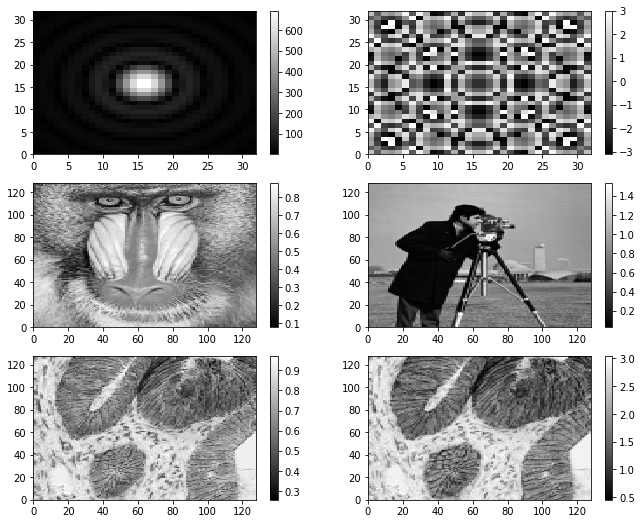

In [7]:
plt.figure(figsize=[11,9])
for n, item in enumerate([probe_airy, obj1, obj2]):
    plt.subplot(3, 2, n * 2 + 1)
    plt.pcolormesh(np.abs(item), cmap='gray')
    plt.colorbar()
    plt.subplot(3, 2, n * 2 + 2)
    plt.pcolormesh(np.angle(item), cmap='gray')
    plt.colorbar()
plt.show()

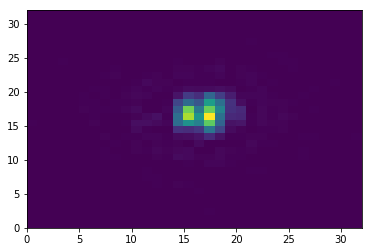

In [8]:
plt.figure()
plt.pcolormesh(diffs[5])
plt.show()

In [9]:
obj1_guess = np.random.random(obj1.shape) * np.exp(1j * np.random.random(obj1.shape))
obj2_guess = np.random.random(obj1.shape) * np.exp(1j * np.random.random(obj1.shape))

In [10]:
tf.reset_default_graph()
with tf.device('/gpu:0'):
    tf_diffs = tf.constant(np.fft.fftshift(diffs, axes=(1,2)), dtype='float32')
    
    tf_obj1_real = tf.Variable(np.real(obj1_guess), dtype='float32')
    tf_obj1_imag = tf.Variable(np.imag(obj1_guess), dtype='float32')
    tf_obj1 = tf.complex(tf_obj1_real, tf_obj1_imag)    
    
    tf_obj2_real = tf.Variable(np.real(obj2_guess), dtype='float32')
    tf_obj2_imag = tf.Variable(np.imag(obj2_guess), dtype='float32')
    tf_obj2 = tf.complex(tf_obj2_real, tf_obj2_imag)   
    
    tf_probe = tf.constant(probe_airy, dtype='complex64') 
    
    probe_npix = probe_airy.shape[0]    

In [11]:
clipped_obj1 = tensor_clip(tf_obj1, max_abs=1.0)
obj1_clip_op = [tf_obj1_real.assign(tf.real(clipped_obj1)),
               tf_obj1_imag.assign(tf.imag(clipped_obj1))]
clipped_obj2 = tensor_clip(tf_obj2, max_abs=1.0)
obj2_clip_op = [tf_obj2_real.assign(tf.real(clipped_obj2)),
               tf_obj2_imag.assign(tf.imag(clipped_obj2))]

In [12]:
tf_view_indices = tf.constant(genViewIndices(probe_npix, positions, obj1.shape))

In [13]:
tf_obj1_views = tf.gather(tf.reshape(tf_obj1, [-1]), tf_view_indices)
tf_obj1_views = tf.reshape(tf_obj1_views, [diffs.shape[0], probe_npix, probe_npix])
tf_obj2_views = tf.gather(tf.reshape(tf_obj2, [-1]), tf_view_indices)
tf_obj2_views = tf.reshape(tf_obj2_views, [diffs.shape[0], probe_npix, probe_npix])

In [14]:
batch_size = diffs.shape[0]
dataset_indices = tf.data.Dataset.range(diffs.shape[0])
dataset_indices = dataset_indices.shuffle(buffer_size=diffs.shape[0])
dataset_indices = dataset_indices.repeat()
dataset_batch = dataset_indices.apply(tf.contrib.data.batch_and_drop_remainder(batch_size))
dataset_batch = dataset_batch.prefetch(50)

Instructions for updating:
Use the retry module or similar alternatives.


In [15]:
iterator = dataset_batch.make_one_shot_iterator()

batchi = iterator.get_next()
batch_indices = tf.Variable(tf.zeros(batch_size, dtype=tf.int64), 
                                     dtype=tf.int64, trainable=False)
assign_op = batch_indices.assign(batchi)

batch_diffs = tf.gather(tf_diffs, batch_indices)
batch_obj1_views = tf.gather(tf_obj1_views, batch_indices)
batch_obj2_views = tf.gather(tf_obj2_views, batch_indices)

In [16]:
batch_exit_waves_1 = tf.fft2d(batch_obj1_views * tf_probe) / probe_npix
batch_exit_waves_2 = tf.fft2d(batch_obj2_views * batch_fftshift2d(batch_exit_waves_1)) / probe_npix
loss = tf.reduce_mean((tf.abs(batch_exit_waves_2) - tf.sqrt(batch_diffs))**2)

In [17]:
obj1_opt = tf.train.AdamOptimizer(learning_rate=1e-1)
obj1_min = obj1_opt.minimize(loss, var_list=[tf_obj1_real, tf_obj1_imag])

obj2_opt = tf.train.AdamOptimizer(learning_rate=1e-1)
obj2_min = obj1_opt.minimize(loss, var_list=[tf_obj2_real, tf_obj2_imag])

In [18]:
init = tf.global_variables_initializer()
sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True    
session = tf.Session(config=sess_config)
session.run(init)
session.run(assign_op)
lossvals = []

In [19]:
for i in range(2000):
    _, __, lossval = session.run([obj1_min, obj2_min, loss])
    lossvals.append(lossval)
    if i % 5 == 0:
        session.run([obj1_clip_op, obj2_clip_op])
    if i % 100 == 0:
        print(lossval)
pr_obj1, pr_obj2 = session.run([tf_obj1, tf_obj2])

2065.5193
204.51804
115.75095
9.622002
0.7578409
0.6684449
0.649569
0.6442317
0.6426631
0.6417973
0.64123285
0.640867
0.640581
0.64031535
0.6400642
0.6397711
0.6394852
0.63974065
0.6397621
0.63938963


In [20]:
pr_obj1, pr_obj2 = session.run([tf_obj1, tf_obj2])

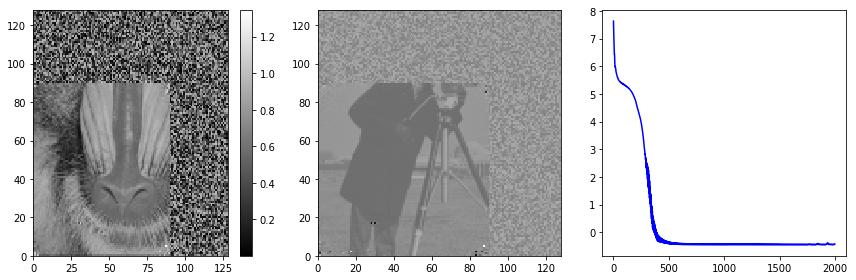

In [21]:
plt.figure(figsize=[12,4])
plt.subplot(1,3,1)
plt.pcolormesh(np.abs(pr_obj1), cmap='gray')
plt.colorbar()
plt.subplot(1,3,2)
plt.pcolormesh(np.angle(pr_obj1), cmap='gray')
plt.subplot(1,3,3)
plt.plot(np.log(lossvals), color='blue')
plt.tight_layout()
plt.show()

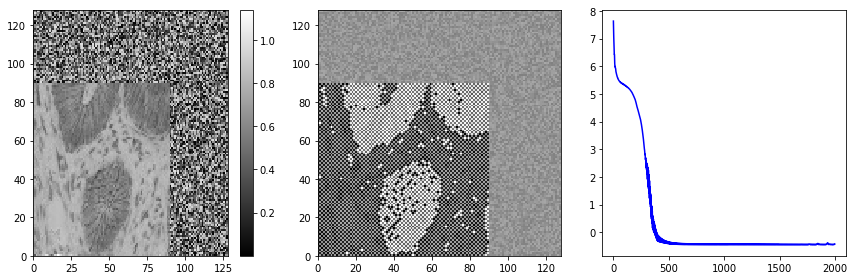

In [22]:
plt.figure(figsize=[12,4])
plt.subplot(1,3,1)
plt.pcolormesh(np.abs(pr_obj2), cmap='gray')
plt.colorbar()
plt.subplot(1,3,2)
plt.pcolormesh(np.angle(pr_obj2), cmap='gray')
plt.subplot(1,3,3)
plt.plot(np.log(lossvals), color='blue')
plt.tight_layout()
plt.show()